In [13]:
#import sys
#sys.path.append('/usr/local/lib/python3.5/site-packages')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from scipy.optimize import curve_fit
from IPython.display import Image
import os

def lineal(x, a, b):
  return a*x + np.log10(b)

In [14]:
# Leemos el archivo
myFolder=(os.getcwd()+'/tc01_data/') #busca en el directorio actual

# Primero creamos la red: 
# Primero creamos la red: 
data1 = pd.read_csv(myFolder+'yeast_Y2H.txt', sep='\t', header=None)
Y2H=nx.Graph()
for i in range(len(data1)):
    Y2H.add_edges_from([(data1[0][i],data1[1][i])])


In [15]:
#eliminamos nodos aislados:
aislados=list(nx.isolates(Y2H))
Y2H.remove_nodes_from(aislados)

#Matriz de Adjacencia Aij:
C_adj = nx.to_numpy_matrix(Y2H) 
#N_adj = nx.to_numpy_matrix(net)

nodos = Y2H.number_of_nodes()
#nodosN = net.number_of_nodes()

In [ ]:
#Grafico: Toda la red
plt.figure(1)
pos = nx.spring_layout(Y2H)
nodes=nx.draw_networkx_nodes(Y2H,pos,cmap=plt.get_cmap('Dark2'),node_color=list(dict(Y2H.degree).values()),width=0.5,node_size=20,with_labels=False) 
edges=nx.draw_networkx_edges(Y2H,pos,edge_color='k',width=0.1)
#nx.draw_networkx_labels(colab,pos,font_size=5)
plt.sci(nodes)
plt.colorbar()
plt.title('Red Y2H por grados \n Componente gigante')
plt.show()

#Grafico: componente gigante

plt.figure(2)
giant = max(nx.connected_component_subgraphs(Y2H), key=len)
pos = nx.spring_layout(giant)
nodes=nx.draw_networkx_nodes(giant,pos,cmap=plt.get_cmap('Dark2'),node_color=list(dict(giant.degree).values()),width=0.5,node_size=20,with_labels=False) 
edges=nx.draw_networkx_edges(giant,pos,edge_color='k',width=0.1)
#nx.draw_networkx_labels(giant,pos,font_size=5)
plt.sci(nodes)
plt.colorbar()
plt.title('Red Y2H por grados \n Componente gigante')
plt.show()

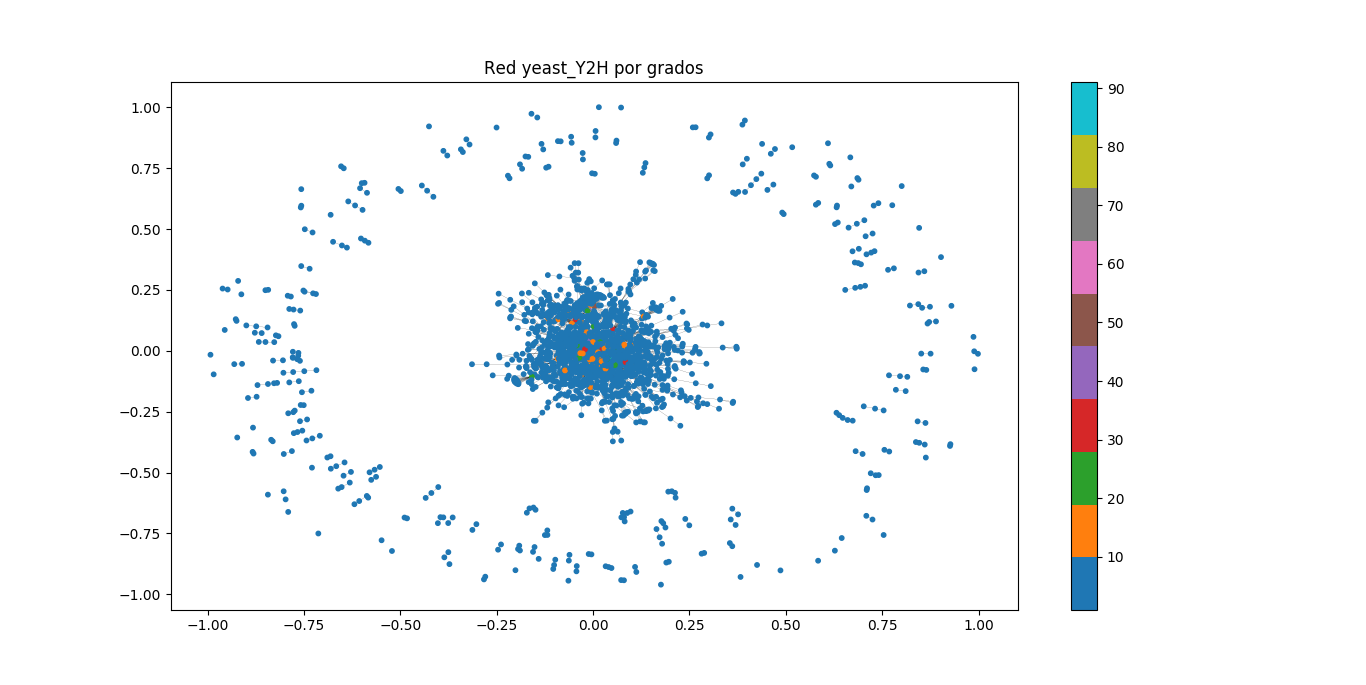

In [3]:
Image(filename='Red_Y2H/Red Y2H.png')


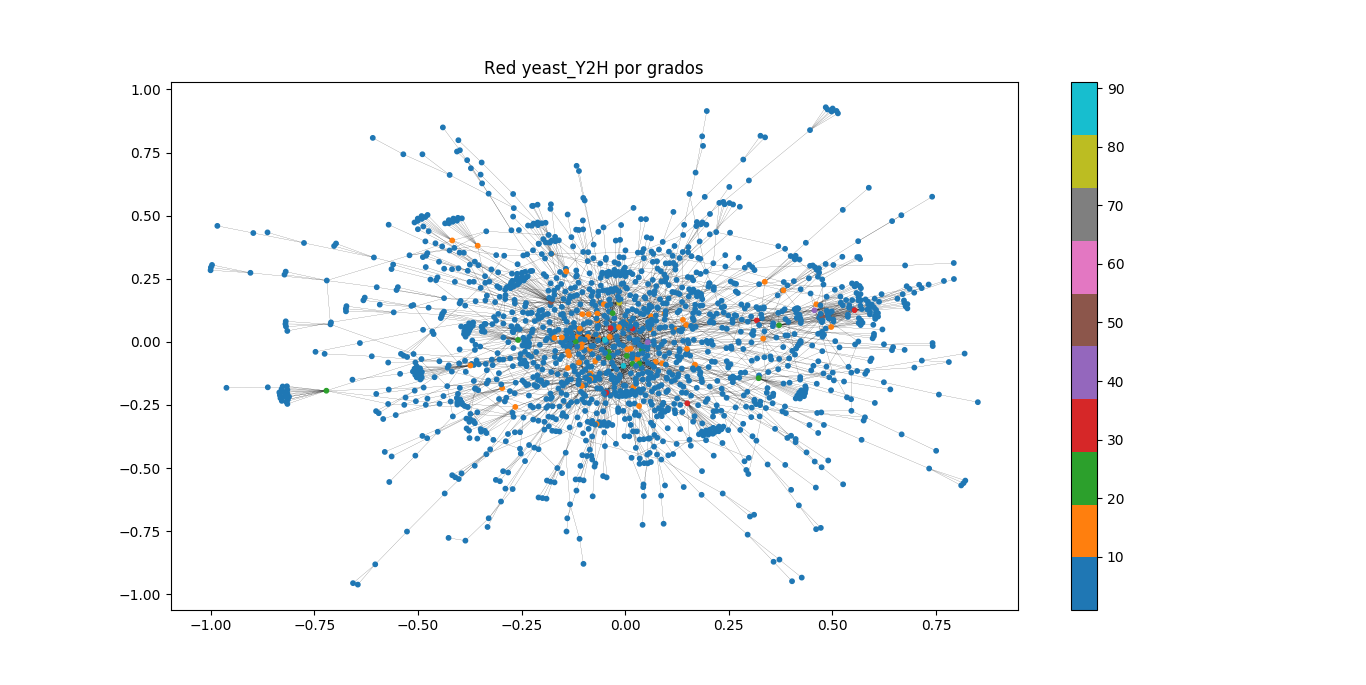

In [4]:
Image(filename='Red_Y2H/Red Y2H-cg.png')

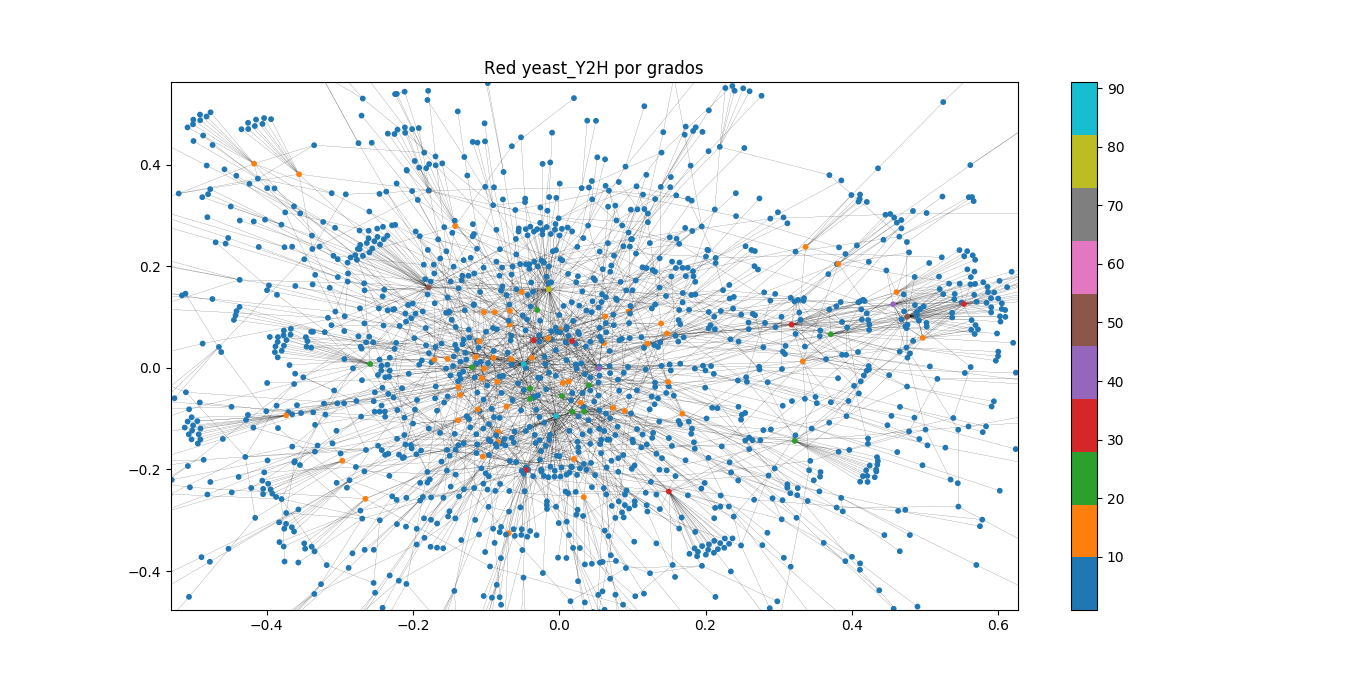

In [5]:
Image(filename='Red_Y2H/Red Y2H-cg-2.png')

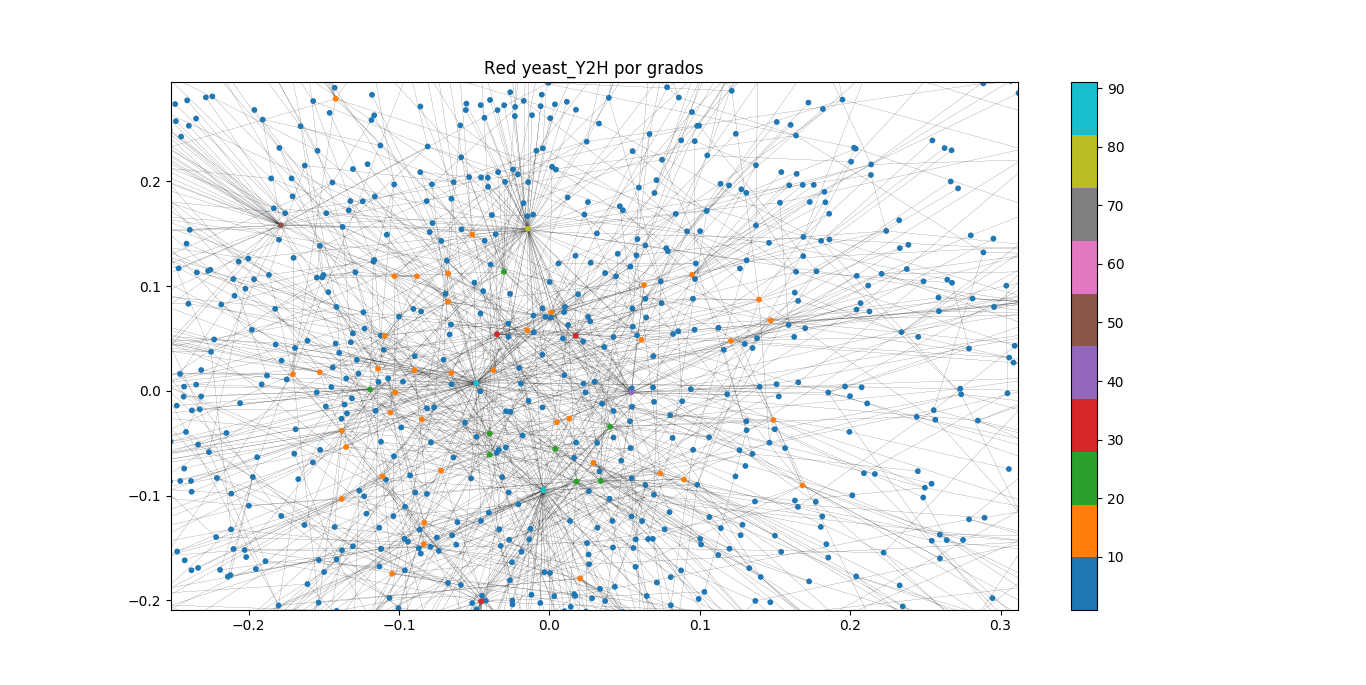

In [6]:
Image(filename='Red_Y2H/Red Y2H-cg-3.png')

In [16]:
#i)
# k_nodo es el vector de grado de cada nodo
# knn_nodo es el valor, de grado promedio de vecinos de cada nodo
k_nodo= [val for (node, val) in Y2H.degree()]
knn_nodo=np.zeros(len(k_nodo))

for i in range(len(k_nodo)):
        knn_nodo[i] = np.dot(np.array(C_adj[i,:]), np.array(k_nodo)) / int(k_nodo[i]) #k_nodo[i] numero de vecinos propios para promediar.


In [17]:
#ii)Grafico de knn en funcion del grado k:
#Tenemos que promediar:

#Ordenar el knn_nodo en funcion del key del k_nodo
knn_nodo=[x for _,x in sorted(zip(k_nodo,knn_nodo))]
knn_nodo=np.array(knn_nodo) 
#Ordenamos el k_nodo
k_nodo=np.sort(k_nodo)

#k es el vector de grados
k=np.unique(k_nodo)
knn=np.zeros(len(k))
knn_error=np.zeros(len(k))

for i,j in enumerate(k):
    v=np.where(k_nodo==j)
    knn[i]=np.mean(knn_nodo[v])
    knn_error[i]=np.std(knn_nodo[v],ddof=1)#ddof=significa degree of freedom en el calculo de la desviacion standar.
                                           #Creo que es mejor con ddof=1 porque si es un solo valor(el error no estaria definido)
                                           #y entonces asigna correctamente nan como error en vez de error 0 lo cual no estaria bien.         
    


/home/danilo/.local/lib/python3.5/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/danilo/.local/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
#iii) Ajuste: con funcion log(knn)=mu*(logk)+log(b)

#AJuste 1: usando los puntos rojos
parametros1=curve_fit(lineal,np.log10(k_nodo),np.log10(knn_nodo))[0]
mu1=parametros1[0]
b1=parametros1[1]
intercept1=np.log10(b1)

print ('Ajuste rojo')
print ('exponente = {0:.3f}'.format(mu1))
print ('intercept = {0:.3f}'.format(intercept1))
print('\n')


xfit1=np.linspace(1,40,1000)
yfit1=(b1)*(xfit1**mu1)

#Ajuste 2: usando los puntos azules

parametros2=curve_fit(lineal,np.log10(k),np.log10(knn))[0]
mu2=parametros2[0]
b2=parametros2[1]
intercept2=np.log10(b2)

print ('Ajuste azul')
print ('exponente = {0:.3f}'.format(mu2))
print ('intercept = {0:.3f}'.format(intercept2))
print('\n')

xfit2=np.linspace(1,40,1000)
yfit2=(b2)*(xfit2**mu2)

#AJuste 3: usando los puntos azules del grafico knn(k) y usando tambien el error:
#Para el ajuste con errores me quedo con puntos que tengan knn_error != nan
nonan_positions=[i for i,j in enumerate(knn_error) if np.invert(np.isnan(j))==True]
knn_error=knn_error[nonan_positions]
knn_fit=knn[nonan_positions]
k_fit=k[nonan_positions]

parametros3=curve_fit(lineal,np.log10(k_fit),np.log10(knn_fit),sigma=(1/np.log(10))*(1/knn_fit)*knn_error)[0]
mu3=parametros3[0]
b3=parametros3[1]
intercept3=np.log10(b3)

print ('Ajuste puntos azules con errores')
print ('exponente = {0:.3f}'.format(mu3))
print ('intercept = {0:.3f}'.format(intercept3))
print('\n')


xfit3=np.linspace(1,40,1000)
yfit3=(b3)*(xfit2**mu3)

Ajuste rojo
exponente = 0.267
intercept = 0.678


Ajuste azul
exponente = -0.163
intercept = 1.161


Ajuste puntos azules con errores
exponente = -0.257
intercept = 1.286




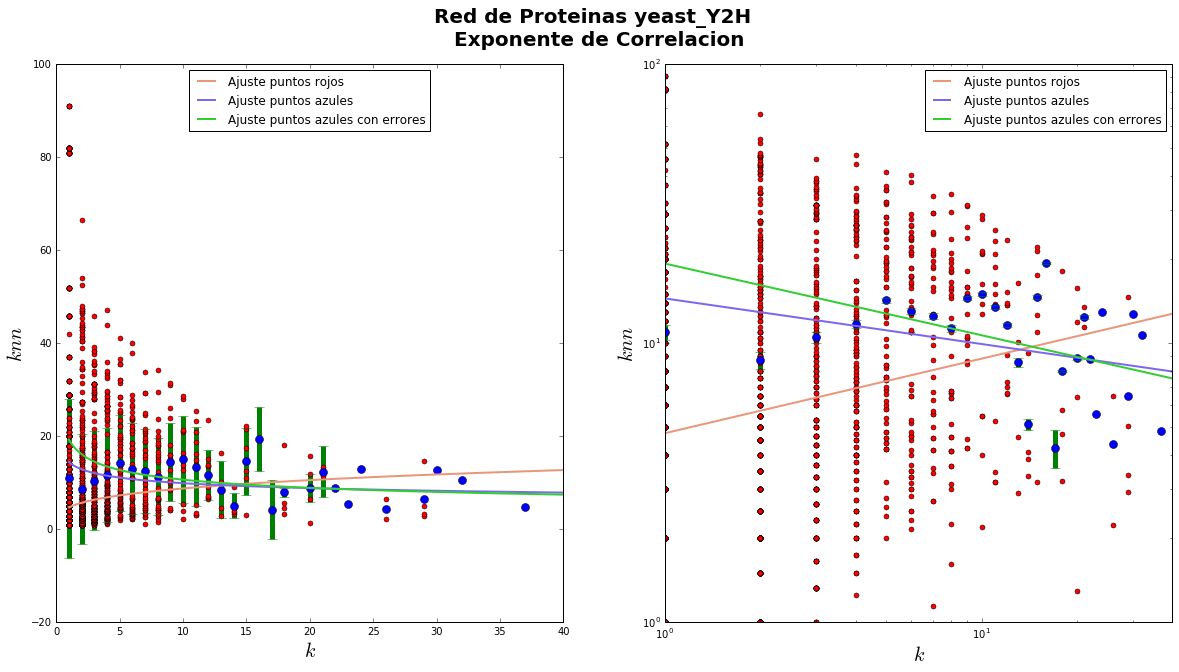

In [21]:
#Graficos
plt.figure(figsize=(20,10))
plt.suptitle('Red de Proteinas yeast_Y2H \n Exponente de Correlacion',size=20,fontweight="bold")
plt.subplot(1,2,1)
#Puntos rojos
plt.plot(k_nodo,knn_nodo,'ro',markersize=5)
#Puntos azules
plt.plot(k,knn,'bo',markersize=8)
#Puntos azules con barra de error=desv standar
plt.errorbar(k_fit,knn_fit,knn_error,fmt=' ',ecolor='green',elinewidth=5,capsize=5,markersize=3)
#AJustes:
plt.plot(xfit1,yfit1,color='darksalmon',label='Ajuste puntos rojos',linewidth=2)
plt.plot(xfit2,yfit2,color='mediumslateblue',label='Ajuste puntos azules',linewidth=2)
plt.plot(xfit3,yfit3,color='limegreen',label='Ajuste puntos azules con errores',linewidth=2)
#Propiedades grafico:
plt.xlabel('$k$',fontsize=20)
plt.ylabel('$knn$',fontsize=20)
plt.xlim(0,40)
#plt.title('Red de Colaboradores Cientificas (netscience) \n Exponente de Correlacion',size=15,fontweight="bold")
plt.legend(loc='upper center')

plt.subplot(1,2,2)
#Puntos rojos
plt.plot(k_nodo,knn_nodo,'ro',markersize=5)
#Puntos azules
plt.plot(k,knn,'bo',markersize=8)
#Puntos azules con barra de error=desv standar
plt.errorbar(k_fit,knn_fit,(1/np.log(10))*(1/knn_fit)*knn_error,fmt=' ',ecolor='green',elinewidth=5,capsize=5,markersize=3)

#AJustes:
plt.plot(xfit1,yfit1,color='darksalmon',label='Ajuste puntos rojos',linewidth=2)
plt.plot(xfit2,yfit2,color='mediumslateblue',label='Ajuste puntos azules',linewidth=2)
plt.plot(xfit3,yfit3,color='limegreen',label='Ajuste puntos azules con errores',linewidth=2)
#Propiedades grafico:
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$',fontsize=20)
plt.ylabel('$knn$',fontsize=20)
plt.xlim(0,40)

plt.legend(loc='upper right')
plt.savefig('y2h.png')
plt.show()

In [23]:
#iv)Asortividad con estimador de Newman:
#Segun libro de Newman se puede calcular r de la siguiente forma:
#r=(S1*Se-S2**2)/(S1*S3-S2**2)

S1=np.sum(k_nodo)
S2=np.sum(k_nodo**2)
S3=np.sum(k_nodo**3)

se=0
enlaces=list(Y2H.edges())
for i,e in enumerate(enlaces):
 se=se+Y2H.degree(enlaces[i][0])*Y2H.degree(enlaces[i][1])
Se=2*se

r=(S1*Se-S2**2)/float(S1*S3-S2**2)

print ('Asortatividad Barabasi (mu) = {}'.format(mu3))
print ('Asortatividad Newman (r) = {}'.format(r))

Asortatividad Barabasi (mu) = -0.25692226114105526
Asortatividad Newman (r) = -0.041067211172400114
